# Importing Libraries

In [ ]:
# pip install pyshp

In [1]:
# spark libraries
from pyspark import SparkConf 
from pyspark.context import SparkContext 
from pyspark.sql import * 
from pyspark.sql.functions import * 
from pyspark.sql.functions import date_format
from pyspark.sql.types import * 

#additional libraries
import pandas as pd 
import matplotlib.pyplot as plt
import shapefile as shp

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# addtional function to convert incompatibility in timestamp values between spark & pandas
# https://stackoverflow.com/a/76947136
def convert_to_pandas(spark_df):
    """
    This function will safely convert a spark DataFrame to pandas.
    """
    # Iterate over columns and convert each timestamp column to a string
    timestamp_cols = []
    for column in spark_df.schema:
        if column.dataType == TimestampType():
            # Append column header to list
            timestamp_cols.append(column.name)
            # Set column to string using date_format function
            spark_df = spark_df.withColumn(
                column.name,
                date_format(column.name, "yyyy-MM-dd HH:mm:ss"))
    # Convert to a pandas DataFrame and reset timestamp columns
    pandas_df = spark_df.toPandas()
    for column_header in timestamp_cols:
        pandas_df[column_header] = pandas_df[
            column_header].astype("datetime64[ns]")

    return pandas_df

# Innitiate Session

In [3]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
spark = SparkSession.builder.appName("Cloud_Computing_Project").getOrCreate()
# sc.setLogLevel("INFO")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/18 22:53:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load Data
The data was obtained from kaggle:
<br>"Brazilian E-Commerce Public Dataset by Olist"<br>
https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/code?datasetId=55151&sortBy=voteCount

In [4]:
schema_orders = StructType([
    StructField("order_id", StringType(), False),
    StructField("customer_id", StringType(), False),
    StructField("order_status", StringType(), True),
    StructField("order_purchase_timestamp", TimestampType(), True),
    StructField("order_approved_at", TimestampType(), True),
    StructField("order_delivered_carrier_date", TimestampType(), True),
    StructField("order_delivered_customer_date", TimestampType(), True),
    StructField("order_estimated_delivery_date", TimestampType(), True)
])

schema_customers = StructType([
    StructField("customer_id", StringType(), False),
    StructField("customer_unique_id", StringType(), False),
    StructField("customer_zip_code_prefix", StringType(), True),
    StructField("customer_city", StringType(), True),
    StructField("customer_state", StringType(), True)
])

schema_geolocation = StructType([
    StructField("geolocation_zip_code_prefix", StringType(), False),
    StructField("geolocation_lat", DoubleType(), False),
    StructField("geolocation_lng", DoubleType(), False),
    StructField("geolocation_city", StringType(), True),
    StructField("geolocation_state", StringType(), True)
])

In [5]:
df_orders = spark.read.option("header", True).schema(schema_orders).csv('olist_orders_dataset.csv')
df_customers = spark.read.option("header", True).schema(schema_customers).csv('olist_customers_dataset.csv')
df_geolocation = spark.read.option("header", True).schema(schema_geolocation).csv('olist_geolocation_dataset.csv')
# df_oitems = spark.read.option("header", True).csv('olist_order_items_dataset.csv')
# df_opayments = spark.read.option("header", True).csv('olist_order_payments_dataset.csv')
# df_oreviews = spark.read.option("header", True).csv('olist_order_reviews_dataset.csv')
# df_products = spark.read.option("header", True).csv('olist_products_dataset.csv')
# df_sellers = spark.read.option("header", True).csv('olist_sellers_dataset.csv')
# df_product_cat = spark.read.option("header", True).csv('product_category_name_translation.csv')
# df.show(truncate=False)

## Check Data Schema

In [60]:
df_orders.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)



In [69]:
df_customers.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: string (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)



In [70]:
df_geolocation.printSchema()

root
 |-- geolocation_zip_code_prefix: string (nullable = true)
 |-- geolocation_lat: double (nullable = true)
 |-- geolocation_lng: double (nullable = true)
 |-- geolocation_city: string (nullable = true)
 |-- geolocation_state: string (nullable = true)



# Preprocessing
includes:
* Handling null values
* Handling duplicated values

## Null

### Checking Null Values

In [76]:
convert_to_pandas(df_orders).isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [66]:
df_customers.toPandas().isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [67]:
df_geolocation.toPandas().isnull().sum()

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

### Drop null values
Out of all tables, only orders table that contained null values. We will drop those rows since we have almost 100k of data, so it won't affect much in the analysis 

In [74]:
df_orders = df_orders.dropna()
convert_to_pandas(df_orders).isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

## Duplicates
In this data, duplicates are rows with the same values in the key column

### Cheking Duplicated Values

In [37]:
df_orders \
    .groupby('order_id') \
    .count() \
    .where('count > 1') \
    .sort('count', ascending=False) \
    .show()

+--------+-----+
|order_id|count|
+--------+-----+
+--------+-----+



In [91]:
df_customers \
    .groupby('customer_id') \
    .count() \
    .where('count > 1') \
    .sort('count', ascending=False) \
    .show(truncate=False)

+-----------+-----+
|customer_id|count|
+-----------+-----+
+-----------+-----+



In [39]:
df_geolocation \
    .groupby('geolocation_zip_code_prefix') \
    .count() \
    .where('count > 1') \
    .sort('count', ascending=False) \
    .show(truncate=False)

+---------------------------+-----+
|geolocation_zip_code_prefix|count|
+---------------------------+-----+
|24220                      |1146 |
|24230                      |1102 |
|38400                      |965  |
|35500                      |907  |
|11680                      |879  |
|22631                      |832  |
|30140                      |810  |
|11740                      |788  |
|38408                      |773  |
|28970                      |743  |
|36400                      |733  |
|39400                      |724  |
|37701                      |714  |
|35162                      |713  |
|35900                      |709  |
|37200                      |696  |
|88330                      |694  |
|22790                      |687  |
|35700                      |678  |
|36570                      |667  |
+---------------------------+-----+
only showing top 20 rows



### Drop duplicated values
Out of all tables, only geolocation table that contained duplicated values. This duplicates came from the same zip code but slightly different coordinates (lat, lon). Therefore, we can safely drop the duplicated values so the coordinate for the same zip code will refer to the same coordinates

In [40]:
df_geolocation = df_geolocation.dropDuplicates(['geolocation_zip_code_prefix'])

df_geolocation \
    .groupby('geolocation_zip_code_prefix') \
    .count() \
    .where('count > 1') \
    .sort('count', ascending=False) \
    .show(truncate=False)

+---------------------------+-----+
|geolocation_zip_code_prefix|count|
+---------------------------+-----+
+---------------------------+-----+



23/10/19 02:24:11 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1067185 ms exceeds timeout 120000 ms
23/10/19 02:24:11 WARN SparkContext: Killing executors is not supported by current scheduler.
23/10/19 02:24:12 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.

# Analysis

## Creating Views

In [6]:
orders = df_orders.withColumn("order_year", year("order_purchase_timestamp"))
orders = orders.withColumn("order_month", month("order_purchase_timestamp"))

orders.createOrReplaceTempView("orders")
df_customers.createOrReplaceTempView("customers")
df_geolocation.createOrReplaceTempView("geolocation")

## Managing Service Level Agreement (SLA)
In most businesses, SLA often regarded as a metric which need to be monitored. The queries below can be used for several cases (examples provided within each section)

### Maintaining Status
Possible use cases:
* Maintain the percentage of canceled order below certain number
* Maintain the percentage of unavailable order below certain number
* Maintain the percentage of delivered order above certain number
* From the result, there are significant improvements on the percentage of canceled and delivered orders from 2016. What we did differently? Can we look back and learn from there?

In [36]:
status_per_year = spark.sql(""" 
SELECT 
    order_status, 
    order_year, 
    COUNT(*) as order_counts, 
    COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(PARTITION BY order_year) as order_percentage
FROM orders
GROUP BY order_year, order_status
ORDER BY order_year, order_status
""")
status_per_year.show(truncate=False)

+------------+----------+------------+-----------------+
|order_status|order_year|order_counts|order_percentage |
+------------+----------+------------+-----------------+
|canceled    |2016      |26          |7.90273556231003 |
|delivered   |2016      |267         |81.15501519756839|
|invoiced    |2016      |18          |5.47112462006079 |
|processing  |2016      |2           |0.60790273556231 |
|shipped     |2016      |9           |2.73556231003040 |
|unavailable |2016      |7           |2.12765957446809 |
|approved    |2017      |2           |0.00443449147469 |
|canceled    |2017      |265         |0.58757012039644 |
|created     |2017      |4           |0.00886898294938 |
|delivered   |2017      |43428       |96.29054788142170|
|invoiced    |2017      |175         |0.38801800403539 |
|processing  |2017      |240         |0.53213897696282 |
|shipped     |2017      |530         |1.17514024079289 |
|unavailable |2017      |457         |1.01328130196670 |
|canceled    |2018      |334   

### Processing Time
Possible use cases/questions to be answered:
* Understanding and optimizing each processes
* Understanding which process makes user need to wait longer
* How long does a user need to wait until they received the product?
* From the avg_purchase_estimation result, does it make sense to make users wait for almost a month? Assuming most transactions are within the country

In [33]:
process_time = spark.sql(""" 
SELECT
    AVG(DATEDIFF(order_approved_at, order_purchase_timestamp)) as avg_purchase_approved,
    AVG(DATEDIFF(order_delivered_carrier_date, order_approved_at)) as avg_approved_carrier,
    AVG(DATEDIFF(order_delivered_customer_date, order_delivered_carrier_date)) as avg_carrier_customer,
    AVG(DATEDIFF(order_estimated_delivery_date, order_delivered_customer_date)) as avg_customer_estimation,
    AVG(DATEDIFF(order_delivered_customer_date, order_purchase_timestamp)) as avg_purchase_customer,
    AVG(DATEDIFF(order_estimated_delivery_date, order_purchase_timestamp)) as avg_purchase_estimation
FROM orders
""")
process_time.show()

+---------------------+--------------------+--------------------+-----------------------+---------------------+-----------------------+
|avg_purchase_approved|avg_approved_carrier|avg_carrier_customer|avg_customer_estimation|avg_purchase_customer|avg_purchase_estimation|
+---------------------+--------------------+--------------------+-----------------------+---------------------+-----------------------+
|    0.518508073045195|   2.707191430092991|   9.282777921741383|     11.876881296902857|   12.497336125046644|     24.403948069709678|
+---------------------+--------------------+--------------------+-----------------------+---------------------+-----------------------+



### Estimation time
Possible use cases/questions to be answered:
* How accurate is the current estimation?
* From the results, it's clear that the estimation need to be refined

In [35]:
estimation = spark.sql(""" 
SELECT
    SUM(CASE WHEN order_delivered_customer_date = order_estimated_delivery_date THEN 1 ELSE 0 END) AS delivered_on_time,
    SUM(CASE WHEN order_delivered_customer_date < order_estimated_delivery_date THEN 1 ELSE 0 END) AS delivered_early,
    SUM(CASE WHEN order_delivered_customer_date > order_estimated_delivery_date THEN 1 ELSE 0 END) AS delivered_late
FROM orders
""")
estimation.show()

+-----------------+---------------+--------------+
|delivered_on_time|delivered_early|delivered_late|
+-----------------+---------------+--------------+
|                0|          88649|          7827|
+-----------------+---------------+--------------+



## Geospatial Analysis

### Number of Customers by States

<Axes: title={'center': 'Number of customers by state'}, xlabel='state'>

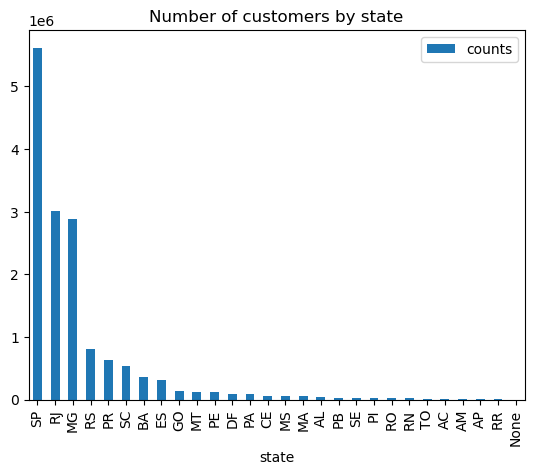

In [17]:
customer_by_states = spark.sql(""" 
SELECT g.geolocation_state as state, COUNT(*) as counts
FROM orders o
LEFT JOIN customers c ON o.customer_id = c.customer_id
LEFT JOIN geolocation g ON c.customer_zip_code_prefix = g.geolocation_zip_code_prefix
GROUP BY state
ORDER BY counts DESC
""")
# customer_by_states.show(truncate=False)
customer_by_states.toPandas().plot(x='state', y='counts', kind='bar', title='Number of customers by state')

### Number of Orders by States

<Axes: title={'center': 'Number of purchase by state'}, xlabel='state'>

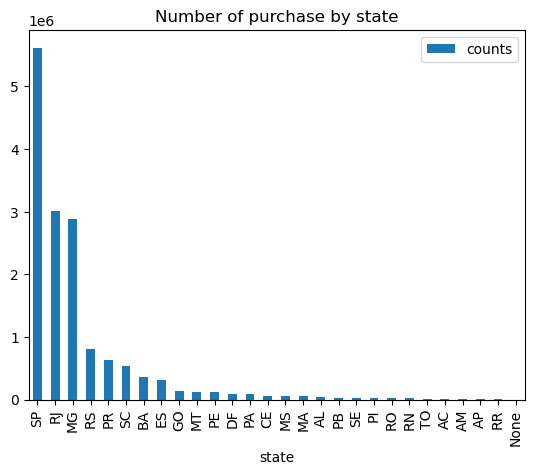

In [19]:
query = """
SELECT g.geolocation_state as state, COUNT(*) AS counts
FROM orders o
LEFT JOIN customers c ON o.customer_id = c.customer_id
LEFT JOIN geolocation g ON c.customer_zip_code_prefix = g.geolocation_zip_code_prefix
GROUP BY g.geolocation_state
ORDER BY counts DESC
"""

order_by_state = spark.sql(query)
# order_by_state.show()
order_by_state.toPandas().plot(x='state', y='counts', kind='bar', title='Number of purchase by state')

### Monthly Orders by States

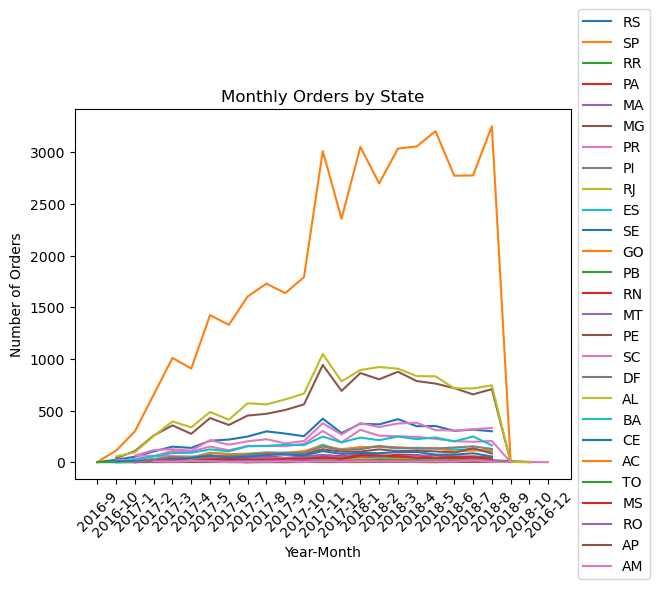

In [115]:
# Extract the year and month from the order_purchase_timestamp column
orders = df_orders.withColumn("order_year", year("order_purchase_timestamp"))
orders = orders.withColumn("order_month", month("order_purchase_timestamp"))

# Join the orders DataFrame with customers and geolocation to get region information
combined_df = orders.join(df_customers, "customer_id").join(df_geolocation, df_customers["customer_zip_code_prefix"] == df_geolocation["geolocation_zip_code_prefix"])

# Group by year, month, and region, and count the number of orders
monthly_orders = combined_df.groupBy("order_year", "order_month", "geolocation_state").count()
monthly_orders = monthly_orders.orderBy(asc("order_year"), asc("order_month"))

# Convert the result to a Pandas DataFrame for plotting
monthly_orders_df = monthly_orders.toPandas()

# Create a plot for each region
regions = monthly_orders_df["geolocation_state"].unique()
for region in regions:
    region_data = monthly_orders_df[monthly_orders_df["geolocation_state"] == region]
    plt.plot(region_data["order_year"].astype(str) + "-" + region_data["order_month"].astype(str), region_data["count"], label=region)

# Set plot title and labels
plt.title('Monthly Orders by State')
plt.xlabel('Year-Month')
plt.ylabel('Number of Orders')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()


### Orders plot map

In [34]:
order_coordinates = spark.sql(""" 
SELECT g.geolocation_lng as lon, g.geolocation_lat as lat, COUNT(*) as counts
FROM orders o
LEFT JOIN customers c ON o.customer_id = c.customer_id
LEFT JOIN geolocation g ON c.customer_zip_code_prefix = g.geolocation_zip_code_prefix
GROUP BY lon, lat
""")
# order_coordinates.show(truncate=False)
order_coordinates = order_coordinates.toPandas()

# Removing some outliers (orders outside of brazil)
#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
order_coordinates = order_coordinates[order_coordinates.lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
order_coordinates = order_coordinates[order_coordinates.lon >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
order_coordinates = order_coordinates[order_coordinates.lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
order_coordinates = order_coordinates[order_coordinates.lon <=  -34.79314722]

# obtain from https://geodata.lib.utexas.edu/catalog/stanford-px089rk5172
sf = shp.Reader("BRA_adm0.shp")

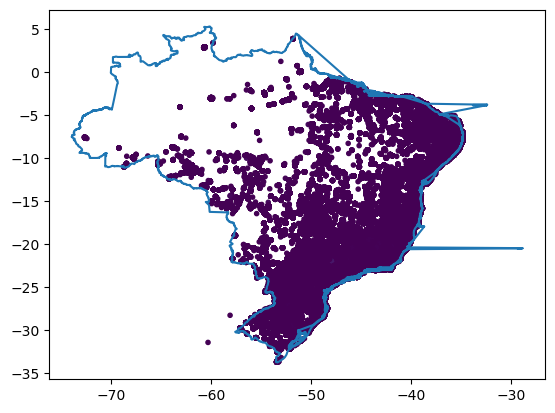

In [32]:
plt.figure()
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y)
    
plt.scatter(order_coordinates.lon, order_coordinates.lat, 
            c=order_coordinates.counts,
            marker = '.')
plt.show()

# Dumped

### Checking the randomness of null data (delete soon)
* need to plot null value with status and date to check ramdomness

In [77]:
df_with_nulls = df_orders.filter(col("order_approved_at").isNull())
result = df_with_nulls.groupBy("order_status").count()
result.show()

+------------+-----+
|order_status|count|
+------------+-----+
|    canceled|  141|
|     created|    5|
|   delivered|   14|
+------------+-----+



In [78]:
df_with_nulls = df_orders.filter(col("order_delivered_carrier_date").isNull())
result = df_with_nulls.groupBy("order_status").count()
result.show()

+------------+-----+
|order_status|count|
+------------+-----+
|    canceled|  550|
|    invoiced|  314|
|     created|    5|
| unavailable|  609|
|  processing|  301|
|    approved|    2|
|   delivered|    2|
+------------+-----+



In [79]:
df_with_nulls = df_orders.filter(col("order_delivered_customer_date").isNull())
result = df_with_nulls.groupBy("order_status").count()
result.show()

+------------+-----+
|order_status|count|
+------------+-----+
|     shipped| 1107|
|    canceled|  619|
|    invoiced|  314|
|     created|    5|
|   delivered|    8|
| unavailable|  609|
|  processing|  301|
|    approved|    2|
+------------+-----+



In [6]:
filtered_df = df_orders.filter(
    (df_orders.order_status != 'delivered') |
    ((df_orders.order_status == 'delivered') &
     (df_orders.order_approved_at.isNull() |
      df_orders.order_delivered_carrier_date.isNull() |
      df_orders.order_delivered_customer_date.isNull()))
)
convert_to_pandas(filtered_df)['order_status'].unique()

array(['invoiced', 'shipped', 'processing', 'unavailable', 'canceled',
       'delivered', 'created', 'approved'], dtype=object)

In [55]:
convert_to_pandas(df_orders).shape

(99441, 8)

In [51]:
df_orders.filter((col("order_status") == 'delivered') & 
                 (df_orders.order_approved_at.isNull() |
                 df_orders.order_delivered_carrier_date.isNull() | 
                 df_orders.order_delivered_customer_date.isNull())
                ).count()

23

In [56]:
convert_to_pandas(filtered_df).shape

(2986, 8)

In [14]:
# filtered_df = df_orders.filter(
#     ((col("order_status") != 'delivered') &
#      (~col('order_approved_at').isNull() |
#       ~col('order_delivered_carrier_date').isNull() |
#       ~col('order_delivered_customer_date').isNull()))
# )
filtered_df = df_orders.na.drop("any")
convert_to_pandas(filtered_df).shape

convert_to_pandas(filtered_df).isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

# Create aggregated data for BI tools

In [13]:
data_cube = spark.sql(""" 
SELECT g.geolocation_state as state, g.geolocation_city as city, o.order_year as year, o.order_month as month, COUNT(*) as order_counts
FROM orders o
LEFT JOIN customers c ON o.customer_id = c.customer_id
LEFT JOIN geolocation g ON c.customer_zip_code_prefix = g.geolocation_zip_code_prefix
GROUP BY CUBE(state, city, year, month)
""")

data_cube.show(truncate=False)

+-----+---------------------+----+-----+------------+
|state|city                 |year|month|order_counts|
+-----+---------------------+----+-----+------------+
|SP   |taboao da serra      |2017|5    |1631        |
|SP   |ferraz de vasconcelos|2018|3    |242         |
|SP   |santos               |2018|3    |19419       |
|SP   |sao vicente          |2017|12   |2256        |
|SP   |cubatao              |2017|11   |711         |
|SP   |cubatao              |2017|6    |296         |
|SP   |jacarei              |2018|3    |894         |
|SP   |bragança paulista    |2018|2    |198         |
|SP   |sumaré               |2018|6    |180         |
|SP   |santa bárbara d'oeste|2017|12   |125         |
|SP   |araras               |2018|8    |1439        |
|SP   |aguai                |2018|2    |164         |
|SP   |são joão da boa vista|2018|6    |71          |
|SP   |guatapara            |2018|4    |29          |
|SP   |cristais paulista    |2017|4    |30          |
|SP   |sorocaba             

## Create data as csv

In [11]:
data_cube.toPandas().to_csv('data_cube.csv', header=True, index=False)